In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import linregress, gmean

plt.style.use('style.mpl')

In [2]:
re = 10  # NAD+/NADH

# per-process efficiencies in [g x s / mol]
g_ana = 50 
g_cat = 50
default_g_resp = 200

# Stoichiometries
S3 = 2/6.    # ATP prod from catabolism [ATP/C]
S5 = 1       # ATP consumption in anab. [ATP/C]

# ATP prod from respiration [ATP/2 NADH]
default_S4 = 4

# NADH consumption in anab. [NADH/C]
default_S6 = 0.1

# Concs in KM units.
ATP_star = 1
NADH_star = 10
O2 = 1

# allocation terms
default_phi_o = 0.3    # biomass is ≈50% protein, ≈20% rRNA.

In [3]:
def calc_mus(phi_o, phi_cat, S4=default_S4, S6=default_S6, g_resp=default_g_resp):
    # kappa constant terms
    k1 = re*re*g_ana              # ≈ f x 10
    k2 = g_cat*(ATP_star**S5)     # ≈ f
    k3 = S5+ATP_star              # ≈ 1
    k4 = 1/g_resp                 # ≈ 1e-2
    
    # remainder is split between anabolism and respiration
    phi_left = 1 - phi_o - phi_cat
    phi_anas = np.linspace(0, phi_left, 100)
    phi_resps = phi_left - phi_anas

    # build up expression from SI
    phi_term = phi_anas*phi_resps
    num = S4*(NADH_star**(S6+2))*k4*k2
    # denom ≈ phi_cat*10 - f*phi_anas*
    denom = S3*k1*phi_cat - k3*k2*phi_anas*(NADH_star**S6)
    mus = num*phi_term/denom
    return mus, phi_anas, phi_resps

In [4]:
phi_results = dict(phi_cat=[], phi_ana=[], phi_resp=[], phi_o=[], mu=[], S6=[])
for my_phi_cat in [0.05, 0.1, 0.15]:
    mus, phi_anas, phi_resps = calc_mus(default_phi_o, my_phi_cat, S6=default_S6)
    phi_results['mu'].extend(mus)
    phi_results['phi_ana'].extend(phi_anas)
    phi_results['phi_resp'].extend(phi_resps)
    phi_results['phi_cat'].extend([my_phi_cat]*len(mus))
    phi_results['phi_o'].extend([default_phi_o]*len(mus))
    phi_results['S6'].extend([default_S6]*len(mus))
phi_res_df = pd.DataFrame(phi_results)
phi_res_df['mu_rel'] = phi_res_df.mu / phi_res_df.mu.max() 
phi_res_df['nu_resp'] = (NADH_star**2)*phi_res_df.phi_resp/default_g_resp
phi_res_df['nu_resp_rel'] = phi_res_df.nu_resp / phi_res_df.nu_resp.max()

phi_res_df.max()

phi_cat        0.150000
phi_ana        0.650000
phi_resp       0.650000
phi_o          0.300000
mu             0.496038
S6             0.100000
mu_rel         1.000000
nu_resp        0.325000
nu_resp_rel    1.000000
dtype: float64

In [5]:
zc_results = dict(phi_cat=[], phi_ana=[], phi_resp=[], phi_o=[], mu=[], S6=[])
for my_S6 in np.arange(-0.5, 0.5, 0.01):
    mus, phi_anas, phi_resps = calc_mus(default_phi_o, phi_cat=0.1, S6=my_S6)
    zc_results['mu'].extend(mus)
    zc_results['phi_ana'].extend(phi_anas)
    zc_results['phi_resp'].extend(phi_resps)
    zc_results['phi_cat'].extend([0.3]*len(mus))
    zc_results['phi_o'].extend([default_phi_o]*len(mus))
    zc_results['S6'].extend([my_S6]*len(mus))
zc_res_df = pd.DataFrame(zc_results)
zc_res_df['ZC'] = -2*zc_res_df.S6 
zc_res_df.head()

,phi_cat,phi_ana,phi_resp,phi_o,mu,S6,ZC
0,0.3,0.000000,0.600000,0.3,0.000000,-0.5,1.0
1,0.3,0.006061,0.593939,0.3,0.000684,-0.5,1.0
2,0.3,0.012121,0.587879,0.3,0.001355,-0.5,1.0
3,0.3,0.018182,0.581818,0.3,0.002014,-0.5,1.0
4,0.3,0.024242,0.575758,0.3,0.002661,-0.5,1.0


In [6]:
gresp_results = dict(phi_cat=[], phi_ana=[], phi_resp=[],
                     phi_o=[], mu=[], S6=[], g_resp=[])
my_phi_cat = 0.1
gresp_phi_remainder = 1 - (my_phi_cat + default_phi_o)
for my_g_resp in [50, 200, 800]:
    mus, phi_anas, phi_resps = calc_mus(default_phi_o, phi_cat=my_phi_cat,
                                        S6=default_S6, g_resp=my_g_resp)
    gresp_results['mu'].extend(mus)
    gresp_results['phi_ana'].extend(phi_anas)
    gresp_results['phi_resp'].extend(phi_resps)
    gresp_results['phi_cat'].extend([0.3]*len(mus))
    gresp_results['phi_o'].extend([default_phi_o]*len(mus))
    gresp_results['S6'].extend([default_S6]*len(mus))
    gresp_results['g_resp'].extend([my_g_resp]*len(mus))
gresp_res_df = pd.DataFrame(gresp_results)
gresp_res_df['ZC'] = -2*gresp_res_df.S6 
gresp_res_df['mu_rel'] = gresp_res_df.mu / gresp_res_df.mu.max()
gresp_res_df['nu_resp'] = (NADH_star**2)*gresp_res_df.phi_resp/gresp_res_df.g_resp
gresp_res_df['nu_resp_rel'] = gresp_res_df.nu_resp / gresp_res_df.nu_resp.max()
gresp_res_df.head()

,phi_cat,phi_ana,phi_resp,phi_o,mu,S6,g_resp,ZC,mu_rel,nu_resp,nu_resp_rel
0,0.3,0.000000,0.600000,0.3,0.000000,0.1,50,-0.2,0.000000,1.200000,1.000000
1,0.3,0.006061,0.593939,0.3,0.010926,0.1,50,-0.2,0.030393,1.187879,0.989899
2,0.3,0.012121,0.587879,0.3,0.021729,0.1,50,-0.2,0.060444,1.175758,0.979798
3,0.3,0.018182,0.581818,0.3,0.032407,0.1,50,-0.2,0.090147,1.163636,0.969697
4,0.3,0.024242,0.575758,0.3,0.042959,0.1,50,-0.2,0.119499,1.151515,0.959596


In [7]:
S4_results = dict(phi_cat=[], phi_ana=[], phi_resp=[],
                  phi_o=[], mu=[], S6=[], S4=[])
my_phi_cat = 0.1
gresp_phi_remainder = 1 - (my_phi_cat + default_phi_o)
for my_S4 in [1, 4, 10]:
    mus, phi_anas, phi_resps = calc_mus(default_phi_o, phi_cat=my_phi_cat,
                                        S6=default_S6, S4=my_S4, g_resp=default_g_resp)
    S4_results['mu'].extend(mus)
    S4_results['phi_ana'].extend(phi_anas)
    S4_results['phi_resp'].extend(phi_resps)
    S4_results['phi_cat'].extend([0.3]*len(mus))
    S4_results['phi_o'].extend([default_phi_o]*len(mus))
    S4_results['S6'].extend([default_S6]*len(mus))
    S4_results['S4'].extend([my_S4]*len(mus))
S4_res_df = pd.DataFrame(S4_results)
S4_res_df['ZC'] = -2*S4_res_df.S6 
S4_res_df['mu_rel'] = S4_res_df.mu / S4_res_df.mu.max()
S4_res_df['nu_resp'] = (NADH_star**2)*S4_res_df.phi_resp/default_g_resp
S4_res_df['nu_resp_rel'] = S4_res_df.nu_resp / S4_res_df.nu_resp.max()
S4_res_df.head()

,phi_cat,phi_ana,phi_resp,phi_o,mu,S6,S4,ZC,mu_rel,nu_resp,nu_resp_rel
0,0.3,0.000000,0.600000,0.3,0.000000,0.1,1,-0.2,0.000000,0.300000,1.000000
1,0.3,0.006061,0.593939,0.3,0.000683,0.1,1,-0.2,0.003039,0.296970,0.989899
2,0.3,0.012121,0.587879,0.3,0.001358,0.1,1,-0.2,0.006044,0.293939,0.979798
3,0.3,0.018182,0.581818,0.3,0.002025,0.1,1,-0.2,0.009015,0.290909,0.969697
4,0.3,0.024242,0.575758,0.3,0.002685,0.1,1,-0.2,0.011950,0.287879,0.959596


/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_75304/2837292724.py:39: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  masked.mu_rel = masked.mu / masked.mu.max()
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_75304/2837292724.py:52: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  masked.mu_rel = masked.mu / masked.mu.max()


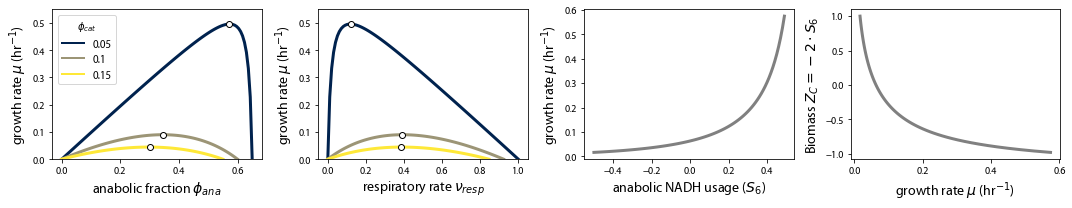

In [27]:
fig, axs = plt.subplots(ncols=4, figsize=(15,3))

plt.sca(axs[0])
lnorm = LogNorm(phi_res_df.phi_cat.min(), phi_res_df.phi_cat.max())
sns.lineplot(data=phi_res_df, x='phi_ana', y='mu', hue='phi_cat',
             palette='cividis', hue_norm=lnorm, lw=3)

max_ids = phi_res_df.groupby('phi_cat').agg(dict(mu='idxmax'))
maxs = phi_res_df.loc[max_ids.mu]
sns.scatterplot(data=maxs, x='phi_ana', y='mu', color='w',
                edgecolor='k', linewidth=1, zorder=10)

plt.legend(loc=2, title='$\phi_{cat}$', fontsize=11)
plt.xlabel('anabolic fraction $\phi_{ana}$', fontsize=14)
plt.ylabel('growth rate $\mu$ (hr$^{-1}$)', fontsize=14)
plt.ylim(0, 0.55)
plt.tick_params(which='both', labelsize=10)
#plt.title('$\phi_{{ana}} + \phi_{{resp}} = {0} - \phi_{{cat}}$'.format((1-default_phi_o))) 

plt.sca(axs[1])
lnorm = LogNorm(phi_res_df.phi_cat.min(), phi_res_df.phi_cat.max())
sns.lineplot(data=phi_res_df, x='nu_resp_rel', y='mu', hue='phi_cat',
             palette='cividis', hue_norm=lnorm, lw=3, legend=False)

sns.scatterplot(data=maxs, x='nu_resp_rel', y='mu', color='w',
                edgecolor='k', linewidth=1, zorder=10, legend=False)

#plt.legend(loc=1, title='$\phi_{cat}$')
plt.xlabel(r'respiratory rate $\nu_{resp}$', fontsize=14)
plt.ylabel('growth rate $\mu$ (hr$^{-1}$)', fontsize=14)
plt.ylim(0, 0.55)
plt.tick_params(which='both', labelsize=10)
#plt.title('$\phi_{{ana}} + \phi_{{resp}} = {0} - \phi_{{cat}}$'.format((1-default_phi_o))) 

plt.sca(axs[2])
mask = np.abs(zc_res_df.phi_ana - 0.4) < 0.001
masked = zc_res_df[mask].copy()
masked.mu_rel = masked.mu / masked.mu.max()

sns.lineplot(data=masked, x='S6', y='mu', lw=3, color='grey')

#plt.legend(loc=1, title='$\phi_{cat}$')
#plt.xlabel('$\phi_{ana}$')
plt.ylabel('growth rate $\mu$ (hr$^{-1}$)', fontsize=14)
plt.xlabel('anabolic NADH usage ($S_6$)', fontsize=14)
plt.tick_params(which='both', labelsize=10)

plt.sca(axs[3])
mask = np.abs(zc_res_df.phi_ana - 0.4) < 0.001
masked = zc_res_df[mask].copy()
masked.mu_rel = masked.mu / masked.mu.max()

sns.lineplot(data=masked, x='mu', y='ZC', lw=3, color='grey')

#plt.legend(loc=1, title='$\phi_{cat}$')
#plt.xlabel('$\phi_{ana}$')
plt.xlabel('growth rate $\mu$ (hr$^{-1}$)', fontsize=14)
plt.ylabel('Biomass $Z_C = -2 \cdot S_6$', fontsize=14)
plt.tick_params(which='both', labelsize=10)

plt.tight_layout()
plt.savefig('../output/analytics_presentation_version.png', dpi=600, facecolor='w')
plt.savefig('../output/analytics_presentation_version.pdf')

plt.show()

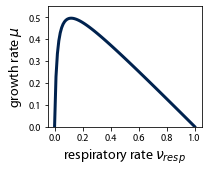

In [9]:
fig, axs = plt.subplots(ncols=1, figsize=(3,2.5))

lnorm = LogNorm(phi_res_df.phi_cat.min(), phi_res_df.phi_cat.max())
mask = phi_res_df['phi_cat'] == 0.05
sns.lineplot(data=phi_res_df[mask], x='nu_resp_rel', y='mu', hue='phi_cat',
             palette='cividis', hue_norm=lnorm, lw=3)

plt.legend().set_visible(False)
plt.xlabel(r'respiratory rate $\nu_{resp}$', fontsize=14)
plt.ylabel('growth rate $\mu$', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.ylim(0, 0.55)

plt.tight_layout()
plt.savefig('../output/too_much_respiration.png', dpi=600, facecolor='w')
plt.show()

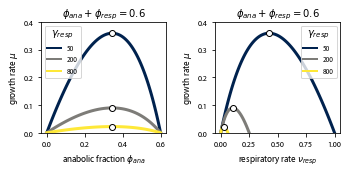

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(5,2.5), sharey=False)

plt.sca(axs[0])
lnorm = LogNorm(gresp_res_df.g_resp.min(), gresp_res_df.g_resp.max())
sns.lineplot(data=gresp_res_df, x='phi_ana', y='mu', hue='g_resp',
             palette='cividis', hue_norm=lnorm, lw=3)

max_ids = gresp_res_df.groupby('g_resp').agg(dict(mu='idxmax'))
maxs = gresp_res_df.loc[max_ids.mu]
sns.scatterplot(data=maxs, x='phi_ana', y='mu', color='w',
                edgecolor='k', linewidth=1, zorder=10)

plt.legend(loc=2, title='$\gamma_{resp}$')
plt.xlabel('anabolic fraction $\phi_{ana}$')
plt.ylabel('growth rate $\mu$')
plt.ylim(0, 0.4)
#plt.yticks(np.arange(0,1.1, 0.5))
plt.title('$\phi_{{ana}} + \phi_{{resp}} = {0}$'.format(gresp_phi_remainder)) 

plt.sca(axs[1])
sns.lineplot(data=gresp_res_df, x='nu_resp_rel', y='mu', hue='g_resp',
             palette='cividis', hue_norm=lnorm, lw=3)

sns.scatterplot(data=maxs, x='nu_resp_rel', y='mu', color='w',
                edgecolor='k', linewidth=1, zorder=10)

plt.legend(loc=1, title='$\gamma_{resp}$')
plt.xlabel(r'respiratory rate $\nu_{resp}$')
plt.ylabel('growth rate $\mu$')
plt.ylim(0, 0.4)
#plt.yticks(np.arange(0,1.1, 0.5))
plt.title('$\phi_{{ana}} + \phi_{{resp}} = {0}$'.format(gresp_phi_remainder)) 

plt.tight_layout()
plt.savefig('../output/analytics_g_resp.png', dpi=600, facecolor='w')
plt.show()

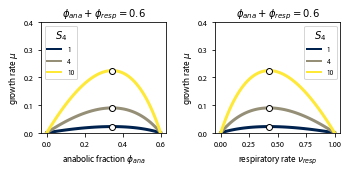

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(5,2.5), sharey=False)

plt.sca(axs[0])
lnorm = LogNorm(S4_res_df.S4.min(), S4_res_df.S4.max())
sns.lineplot(data=S4_res_df, x='phi_ana', y='mu', hue='S4',
             palette='cividis', hue_norm=lnorm, lw=3)

max_ids = S4_res_df.groupby('S4').agg(dict(mu='idxmax'))
maxs = S4_res_df.loc[max_ids.mu]
sns.scatterplot(data=maxs, x='phi_ana', y='mu', color='w',
                edgecolor='k', linewidth=1, zorder=10)

plt.legend(loc=2, title='$S_4$')
plt.xlabel('anabolic fraction $\phi_{ana}$')
plt.ylabel('growth rate $\mu$')
plt.ylim(0, 0.4)
#plt.yticks(np.arange(0,1.1, 0.5))
plt.title('$\phi_{{ana}} + \phi_{{resp}} = {0}$'.format(gresp_phi_remainder)) 

plt.sca(axs[1])
sns.lineplot(data=S4_res_df, x='nu_resp_rel', y='mu', hue='S4',
             palette='cividis', hue_norm=lnorm, lw=3)

sns.scatterplot(data=maxs, x='nu_resp_rel', y='mu', color='w',
                edgecolor='k', linewidth=1, zorder=10)

plt.legend(loc=1, title='$S_4$')
plt.xlabel(r'respiratory rate $\nu_{resp}$')
plt.ylabel('growth rate $\mu$')
plt.ylim(0, 0.4)
#plt.yticks(np.arange(0,1.1, 0.5))
plt.title('$\phi_{{ana}} + \phi_{{resp}} = {0}$'.format(gresp_phi_remainder)) 

plt.tight_layout()
plt.savefig('../output/analytics_g_resp.png', dpi=600, facecolor='w')
plt.show()